In [1]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl
import matplotlib
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

model_info = json.load(open('../param_est/model_info.json', 'r'))
model_names = list(model_info.keys())
display_names = [model_info[model]['display_name'] for model in model_names]

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']

colors = get_color_pallette()
colors.remove(colors[-4]) # remove the second to last color, because we only have 10 models

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load in full Keyes et al. data

In [2]:
# load in the full data
data = {'CYTO':{'inputs':None, 'data':None,'data_std':None, 'times':None},
    'PM':{'inputs':None, 'data':None,'data_std':None, 'times':None}}
data['CYTO']['inputs'], data['CYTO']['data'], data['CYTO']['data_std'], \
    data['CYTO']['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.json', data_std=True, time=True)
data['PM']['inputs'], data['PM']['data'], data['PM']['data_std'], \
    data['PM']['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.json', data_std=True, time=True)
data_time_to_mins = 60

#### Load in all posterior data and samples

In [3]:
# big dictionary to store all the data and access throughout the notebook
training_data = {'40min':{},'30min':{},'20min':{},'10min':{}}
param_post_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
post_pred_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
post_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
log_marg_likes = {'40min':{},'30min':{},'20min':{},'10min':{}}
SAM40_pred_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
SAM40_post_pred_samples = {}

for time_len in ['', '_30min', '_20min', '_10min']:
    datadir = '../../../results/MAPK/param_est/Keyes_2020_data'+time_len+'/'
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'

    # load in the training data
    if time_len == '':
        training_data['40min'] = data
    else:
        data_train = {'CYTO':{'inputs':None, 'data':None,'data_std':None, 'times':None},
            'PM':{'inputs':None, 'data':None,'data_std':None, 'times':None}}
        for compartment in ['CYTO','PM']:
            data_train[compartment]['inputs'], data_train[compartment]['data'], data_train[compartment]['data_std'], \
                data_train[compartment]['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-'+compartment+'-'+time_len.strip('_')+'.json', data_std=True, time=True)
        # store in big dictionary 
        training_data[time_len.strip('_')] = data_train
        
        data_time_to_mins = 60

    # if savedir does not exist, create it
    if not os.path.exists(savedir):
        os.makedirs(savedir)

    idata = {'CYTO':{},'PM':{}}
    post_pred_sampl = {'CYTO':{},'PM':{}}
    post_sampl = {'CYTO':{},'PM':{}}
    sample_times = {'CYTO':{},'PM':{}}
    ss = {'CYTO':{},'PM':{}}
    log_marginal_likes = {'CYTO':[],'PM':[]}

    for model in model_names:
        for compartment in ['CYTO','PM']:
            idata[compartment][model], ss[compartment][model], sample_times[compartment][model] = load_smc_samples_to_idata(datadir+compartment+'/' + model + '/' + model +'_smc_samples.json', sample_time=True)
            post_pred_sampl[compartment][model] = np.load(datadir+compartment+'/' + model + '/' + model +'_posterior_predictive_samples.npy')
            post_sampl[compartment][model] = np.load(datadir+compartment+'/' + model + '/traj_predict.npy')
            
            if model == 'hornberg_2005':
                # Hornberg 2005 only has 800 posterior predictive samples, so we duplicate and randomly permute them to get 2000
                H_2005_posts = [post_pred_sampl[compartment]['hornberg_2005'] for _ in range(3)]
                H_2005_post = np.vstack(H_2005_posts)
                post_pred_sampl[compartment]['hornberg_2005'] = H_2005_post[rng.permutation(np.arange(2000))]

            # now log marginal likelihoods
            _log_marg_like = ss[compartment][model]['log_marginal_likelihood']
            if len(_log_marg_like) == 1:
                log_marginal_likes[compartment].append(np.mean([chain[-1] for chain in _log_marg_like[0]]))
            else:
                log_marginal_likes[compartment].append(np.mean([chain[-1] for chain in _log_marg_like]))
        
    if time_len == '': # in this case some of the posterior predictive samples need to be modified because they are not the same length
        # shin has 4000 so downsample to 2000
        idxs = rng.choice(np.arange(4000), size=2000, replace=False)
        post_pred_sampl['CYTO']['shin_2014'] = post_pred_sampl['CYTO']['shin_2014'][idxs]
        post_pred_sampl['PM']['shin_2014'] = post_pred_sampl['PM']['shin_2014'][idxs]

    # load in the SAM40 posterior samples
    with open(datadir+'SAM40_predictions.json', "r") as json_file:
        SAM40_pred = json.load(json_file)

    # store in the big dictionary
    if time_len == '':
        key = '40min'

        # load in the SAM40 posterior predictive samples
        with open(datadir+'SAM40_post_pred.json', "r") as json_file:
            SAM40_post_pred = json.load(json_file)
    else:
        key = time_len.strip('_')

    param_post_samples[key] = idata
    post_pred_samples[key] = post_pred_sampl
    post_samples[key] = post_sampl
    log_marg_likes[key] = log_marginal_likes
    SAM40_pred_samples[key] = SAM40_pred
    SAM40_post_pred_samples = SAM40_post_pred
    

#### Compute MMI weights, ELPPD estimates and model probabilities

In [4]:
# big dictionary to store all weights
mmi_weights = {'40min':{},'30min':{},'20min':{},'10min':{}}
elpd_ests = {'40min':{},'30min':{},'20min':{},'10min':{}}

for time_len in ['', '_30min', '_20min', '_10min']:
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    ##### Run arviz model comparison ######
    weights = {'CYTO':{'waic_pbma':{},'waic_stack':{},'loo_pbma':{},'loo_stack':{},'bma':{}},
               'PM':{'waic_pbma':{},'waic_stack':{},'loo_pbma':{},'loo_stack':{},'bma':{}}}
    elppd = {'CYTO':{'waic_pbma':{},'loo_pbma':{}},
               'PM':{'waic_pbma':{},'loo_pbma':{}}}

    for compartment in ['CYTO','PM']:
        compare_data_waic_pbma = az.compare(param_post_samples[key][compartment], ic='waic', method='BB-pseudo-BMA', seed=rng)
        weights[compartment]['waic_pbma'] = dict(compare_data_waic_pbma['weight'])
        elppd[compartment]['waic_pbma'] = dict(compare_data_waic_pbma['elpd_waic'])

        compare_data_loo_pbma = az.compare(param_post_samples[key][compartment], ic='loo', method='BB-pseudo-BMA', seed=rng)
        weights[compartment]['loo_pbma'] = dict(compare_data_loo_pbma['weight'])
        elppd[compartment]['loo_pbma'] = dict(compare_data_loo_pbma['elpd_loo'])

        compare_data_waic_stack = az.compare(param_post_samples[key][compartment], ic='waic', method='stacking', seed=rng)
        weights[compartment]['waic_stack'] = dict(compare_data_waic_stack['weight'])

        compare_data_loo_stack = az.compare(param_post_samples[key][compartment], ic='loo', method='stacking', seed=rng)
        weights[compartment]['loo_stack'] = dict(compare_data_loo_stack['weight'])

    ##### Compute model probabilities ######
        # function to compute log sum exponential in a numerically stable way
    def logsumexp(x):
        c = np.max(x)
        return c + np.log(np.sum(np.exp(x - c)))

    def weight_with_logsumexp(log_values):
        return np.exp(log_values - logsumexp(log_values))

    for compartment in ['CYTO','PM']:
        n_models = len(log_marg_likes[key][compartment])
        prior_prob = 1/n_models
        model_probs = weight_with_logsumexp(np.log(prior_prob)+log_marg_likes[key][compartment])
        m_probs = {}
        for i, model in enumerate(model_names):
            m_probs[model] = model_probs[i]

        weights[compartment]['bma'] = m_probs

    # store in big dictionary
    mmi_weights[key] = weights
    elpd_ests[key] = elppd


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto

#### Plot ELPPD estimates and model probabilities

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

_30min


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

_20min


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/Project_4_multimodel-inference/src/MAPK/multimodel_inference/../plotting_helper_funcs.py:11: Runtim

_10min


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3627278080.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

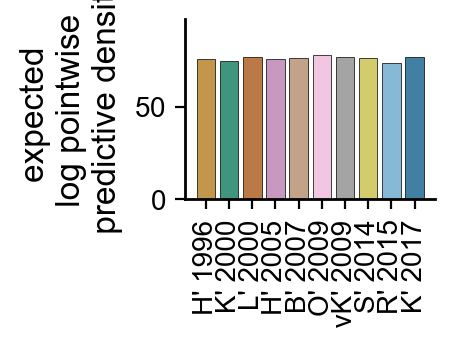

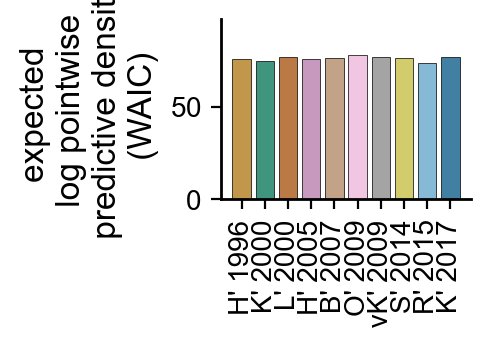

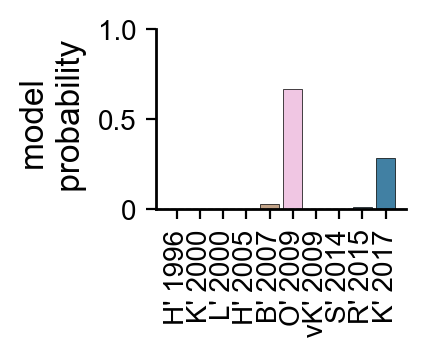

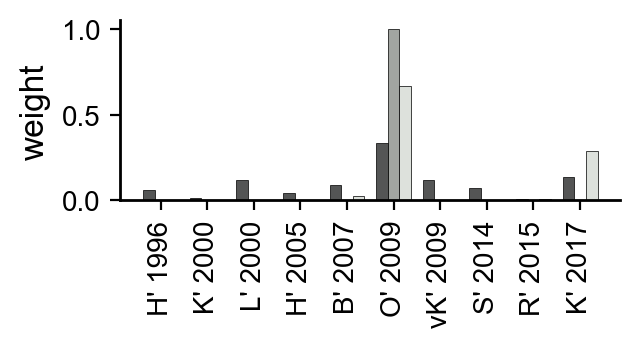

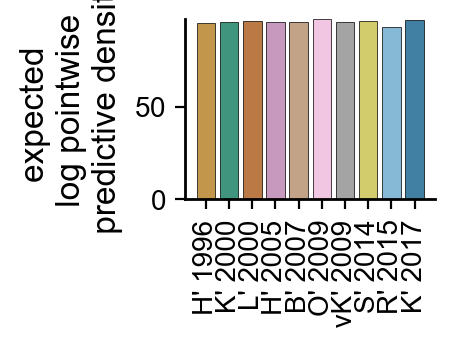

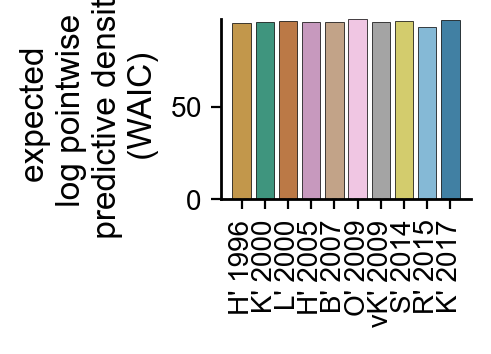

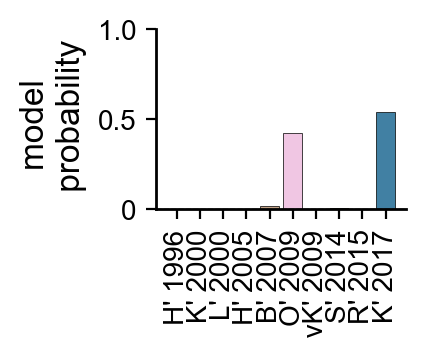

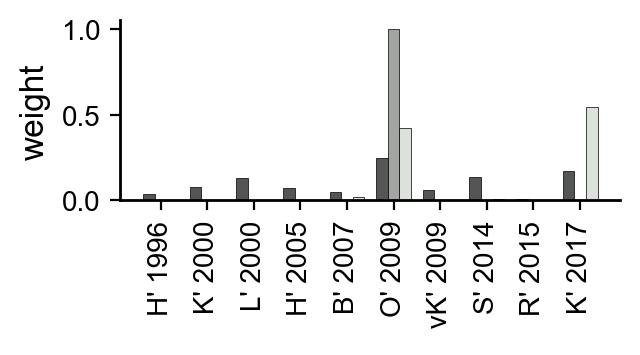

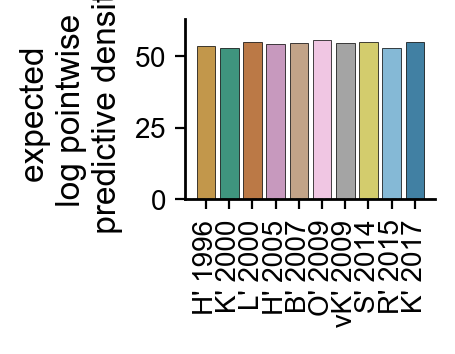

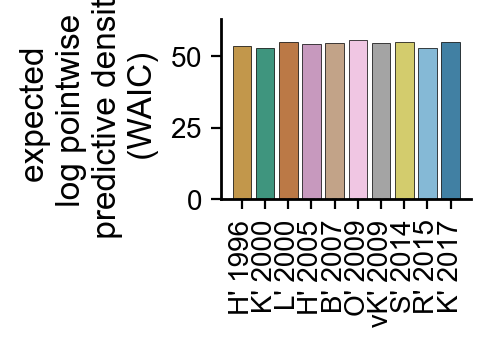

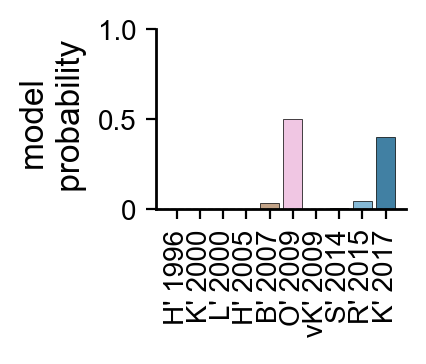

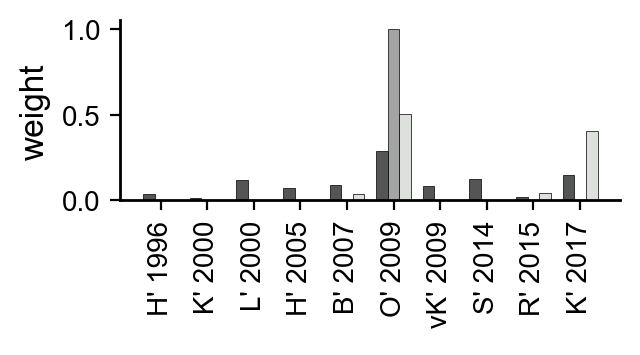

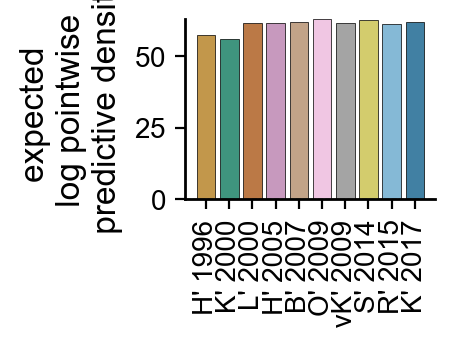

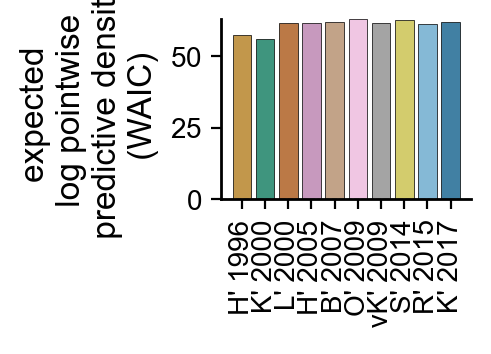

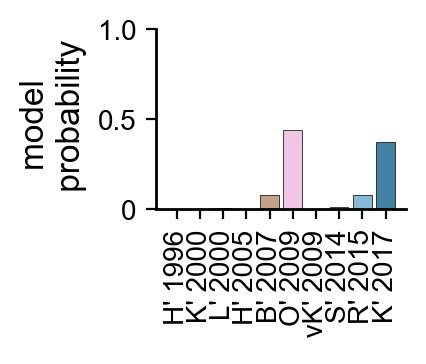

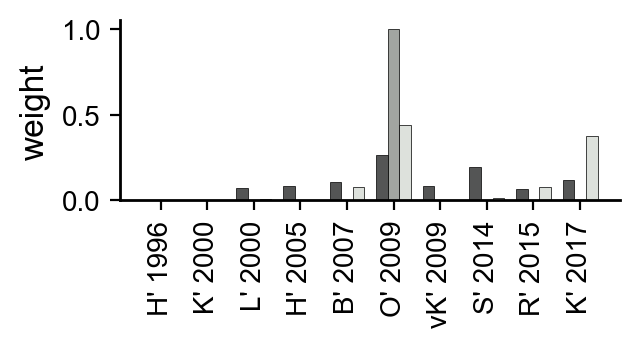

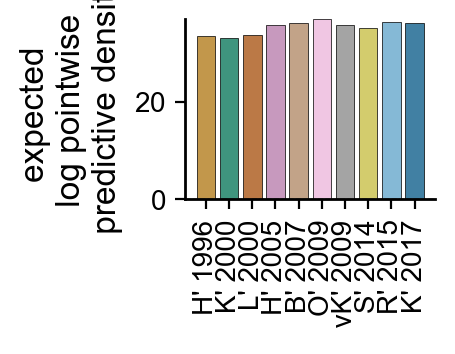

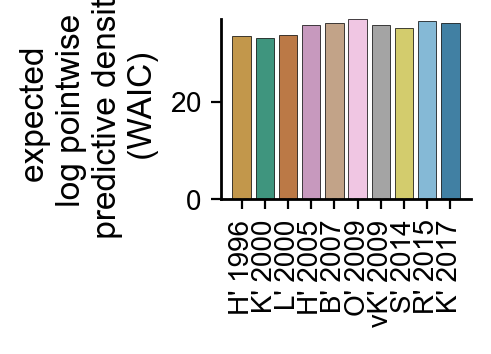

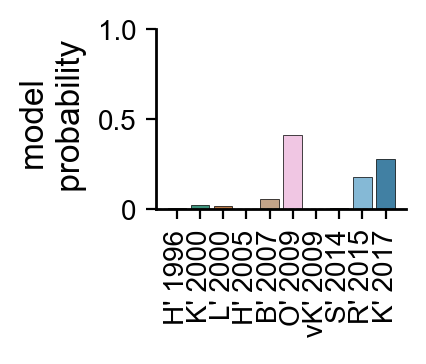

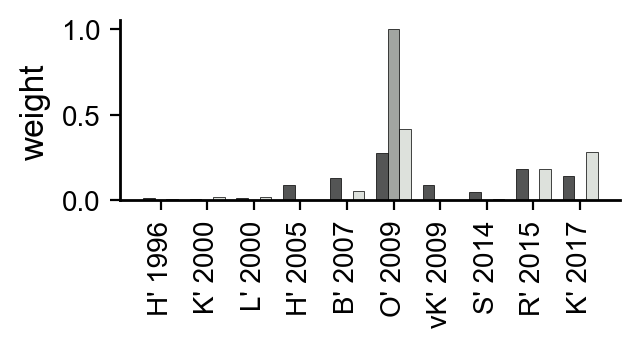

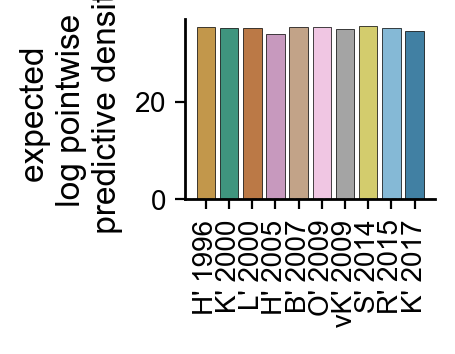

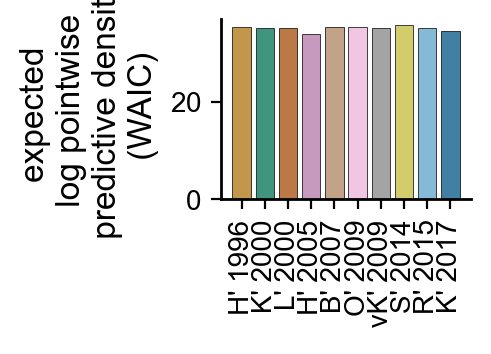

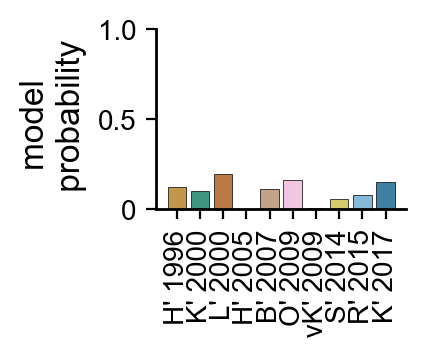

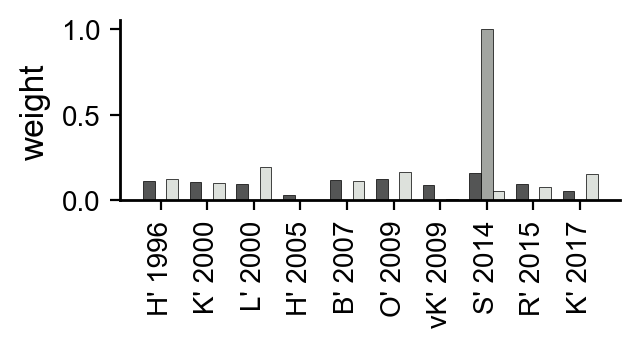

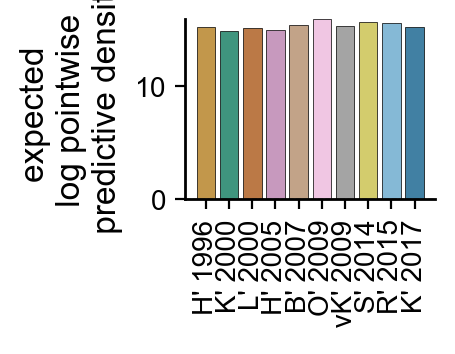

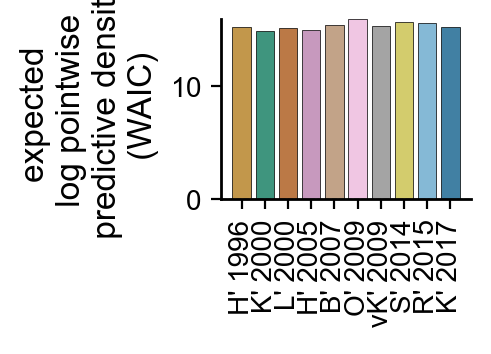

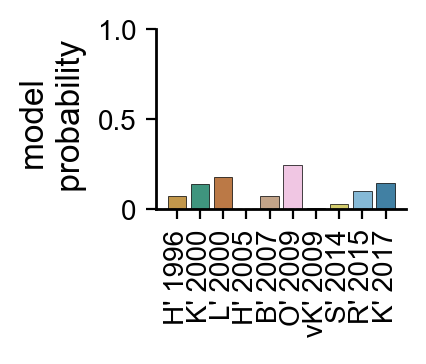

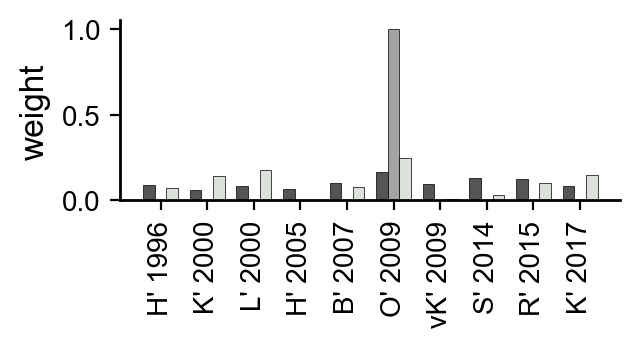

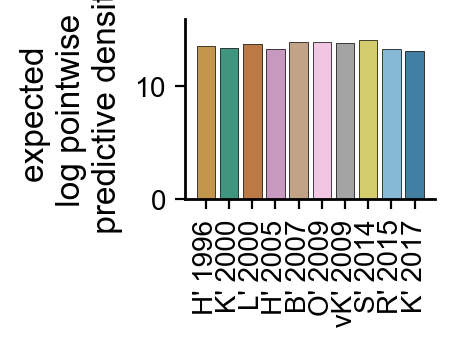

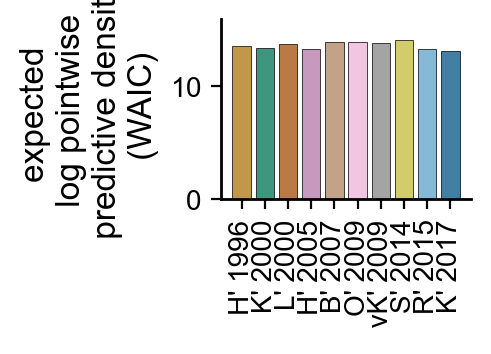

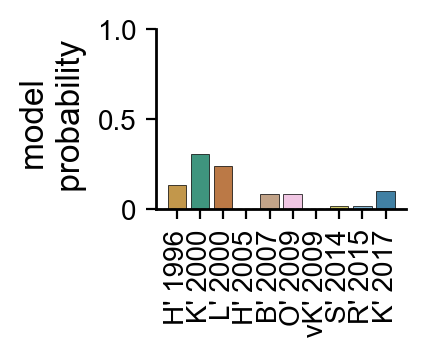

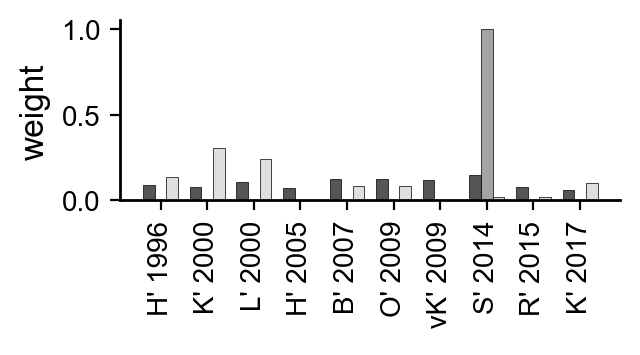

In [5]:
for time_len in ['', '_30min', '_20min', '_10min']:
    print(time_len)
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    ##### make plot of ELPPD, model probabilities, and model weights ######
    # get ylims for all plots
    ylim = [0, 0]
    for compartment in ['CYTO','PM']:
        dat = [elpd_ests[key][compartment]['loo_pbma'][model] for model in model_names]
        
        if np.min(dat) < ylim[0]:
            ylim[0] = np.min(dat)
        if np.max(dat) > ylim[1]:
            ylim[1] = np.max(dat)
    
    for compartment in ['CYTO','PM']: 
        # make a plot of elpd_loo, and elpd_waic
        dat = [elpd_ests[key][compartment]['loo_pbma'][model] for model in model_names]
        fig, ax = get_sized_fig_ax(1.25, 0.9)
        bar = ax.bar(model_names, dat, edgecolor='k', alpha=0.85)
        ax.set_ylabel('expected \n log pointwise \n predictive density', fontsize=12)
        ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])
        xlim = ax.get_xlim()
        ax.plot(xlim, [0,0], '--k', linewidth=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        # ylim = ax.get_ylim()
        # ax.set_ylim(-0.04*ylim[1], 0.5*ylim[1])
        # ax.set_yticks([0, 200.0])
        # ax.set_yticklabels([0, 200.0], fontsize=10.0)
        fig.savefig(savedir + compartment + '_traj_elpd_loo.pdf', transparent=True)

        # waic
        dat = [elpd_ests[key][compartment]['waic_pbma'][model] for model in model_names]
        fig, ax = get_sized_fig_ax(1.25, 0.9)
        bar = ax.bar(model_names, dat, edgecolor='k', alpha=0.85)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])

        ax.set_ylabel('expected \n log pointwise \n predictive density \n (WAIC)', fontsize=12)
        ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0,0], '--k', linewidth=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        # ylim = ax.get_ylim()
        # ax.set_ylim(-0.01*ylim[1], 0.15*ylim[1])
        # ax.set_yticks([0, 200.0])
        # ax.set_yticklabels([0, 200.0], fontsize=10.0)
        fig.savefig(savedir + compartment + '_traj_elpd_waic.pdf', transparent=True)

        # model probabilities
        fig, ax = get_sized_fig_ax(1.25, 0.9)
        bar = ax.bar(model_names, [mmi_weights[key][compartment]['bma'][model] for model in model_names], edgecolor='k', alpha=0.85)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])

        ax.set_ylabel('model \n probability', fontsize=12)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0,0], '--k', linewidth=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim([0, 1.0])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1.0], fontsize=10.0)
        ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
        # ax.set_ylim([0, 1.0])
        fig.savefig(savedir + compartment + '_traj_model_probs.pdf', transparent=True)

        # model weights stacked bar charts
        x = np.arange(n_models)  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0

        stack = [mmi_weights[key][compartment]['loo_stack'][model] for model in model_names]
        pBMA = [mmi_weights[key][compartment]['loo_pbma'][model] for model in model_names]
        bma = [mmi_weights[key][compartment]['bma'][model] for model in model_names]

        fig, ax = get_sized_fig_ax(2.5, 0.9)
        for dat, name, col in zip([pBMA, stack, bma], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
            offset = width * multiplier
            bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k', alpha=0.85)
            # ax.bar_label(bar, padding=3)
            multiplier += 1

        ax.set_ylabel('model weight', fontsize=12)
        ax.set_xticks(x + width, display_names)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
        leg = ax.legend(loc='center', fontsize=8.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
        leg.remove()

        ax.set_ylabel(r'weight', fontsize=12)
        ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
        # ax.set_ylim([0, 1.0])
        fig.savefig(savedir + compartment + '_traj_model_weights.pdf', transparent=True)
# plt.close('all')

In [6]:
dat_c = {model:elpd_ests['40min']['CYTO']['loo_pbma'][model] for model in model_names}
dat_pm = {model:elpd_ests['40min']['PM']['loo_pbma'][model] for model in model_names}

print('CYTO')
sorted_dat_c = sorted(dat_c.items(), key=lambda x: x[1])
for key, value in sorted_dat_c:
    print(key, value)

print('PM')
sorted_dat = sorted(dat_pm.items(), key=lambda x: x[1])
for key, value in sorted_dat:
    print(key, value)

CYTO
ryu_2015 73.40492304964557
kholodenko_2000 74.54643079896124
hornberg_2005 75.63623791148736
huang_ferrell_1996 75.98510397559998
shin_2014 76.04744486718194
birtwistle_2007 76.37834480989045
vonKriegsheim_2009 76.58989563757608
levchenko_2000 76.67698427079564
kochanczyk_2017 76.77462252225078
orton_2009 77.70797443962883
PM
ryu_2015 93.08083720245479
huang_ferrell_1996 95.22437072474034
birtwistle_2007 95.5126219044753
vonKriegsheim_2009 95.70004324972838
hornberg_2005 95.83693773784098
kholodenko_2000 95.94097081378234
levchenko_2000 96.47778172139337
shin_2014 96.4909485203367
kochanczyk_2017 96.74268227431162
orton_2009 97.1283643481338


#### Generate posterior predictive samples and plot MMI traces

/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/Project_4_multimodel-inference/src/MAPK/multimodel_inference/../plotting_helper_funcs.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(fig_width, fig_height))
/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/Project_4_multimodel-inference/src/MAPK/multimodel_inference/../utils.py:970: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(trajectory)


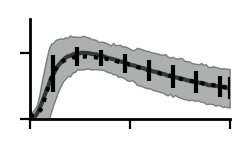

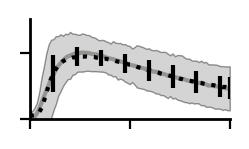

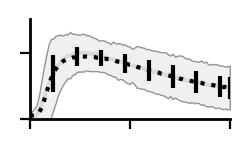

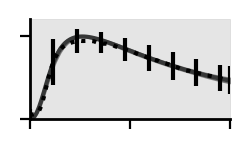

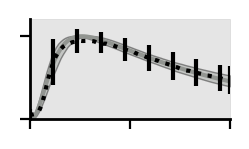

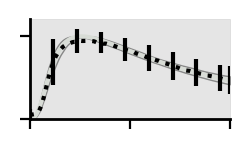

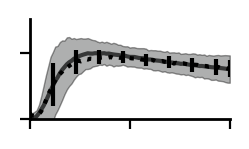

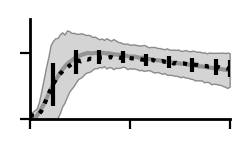

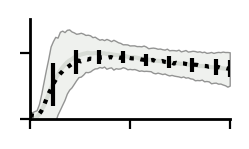

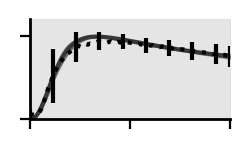

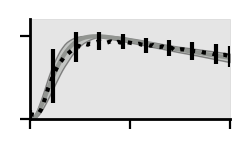

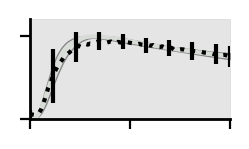

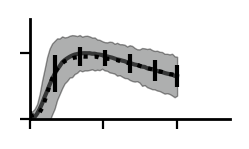

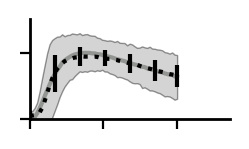

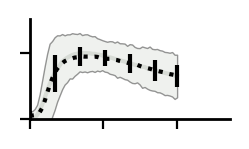

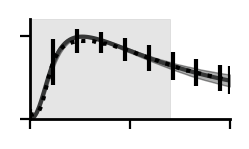

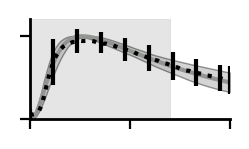

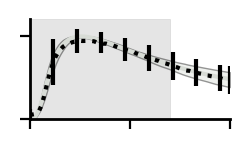

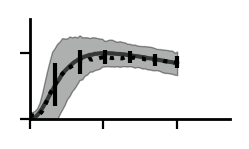

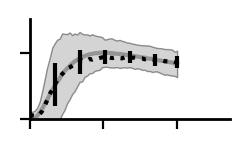

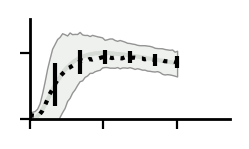

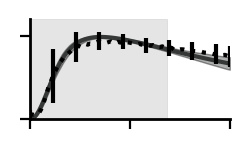

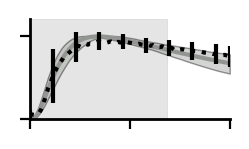

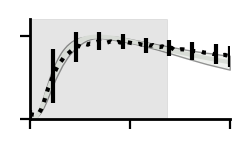

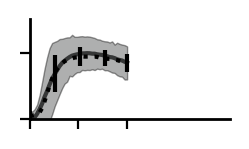

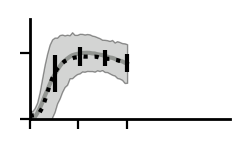

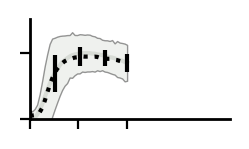

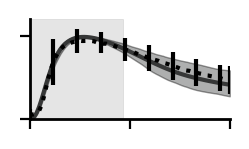

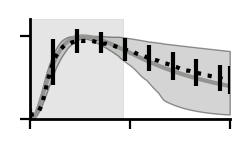

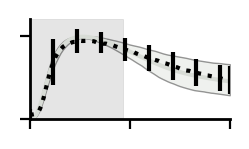

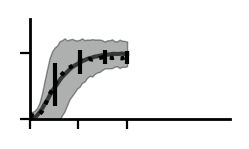

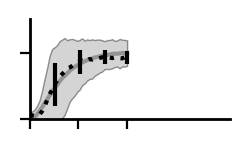

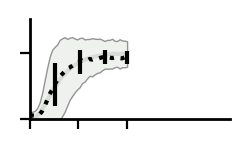

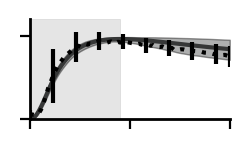

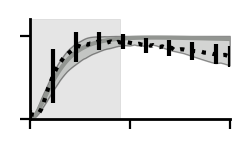

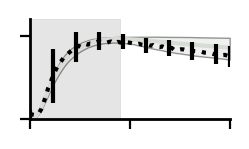

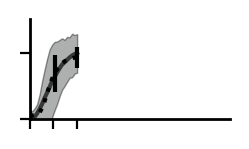

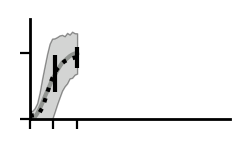

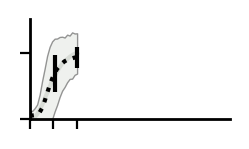

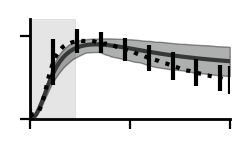

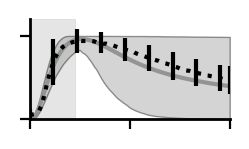

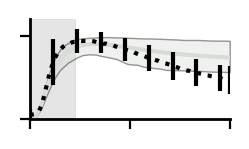

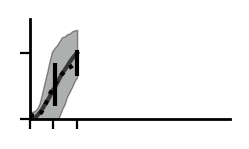

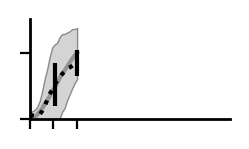

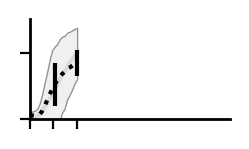

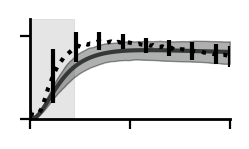

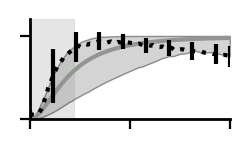

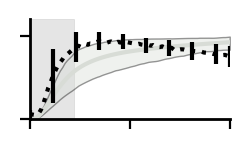

In [7]:
# big dictionaries to save MMI errors and uncertainties
mmi_errors = {'40min':{},'30min':{},'20min':{},'10min':{}}
mmi_uncertainties = {'40min':{},'30min':{},'20min':{},'10min':{}}
mmi_SAM40 = {'40min':{},'30min':{},'20min':{},'10min':{}}
mmi_SAM40_post_pred = {'CYTO':{},'PM':{}}

for time_len in ['', '_30min', '_20min', '_10min']:
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')

    # first with posterior predictive samples
    loo_bma_combined = {}
    loo_stack_combined = {}
    loo_pbma_combined = {}
    loo_bma_combined_post = {}
    loo_stack_combined_post = {}
    loo_pbma_combined_post = {}
    trajs_mmi_ppc = {'CYTO':{},'PM':{}}
    trajs_mmi_post = {'CYTO':{},'PM':{}}
    errors = {'CYTO':{},'PM':{}}
    uncertainties = {'CYTO':{},'PM':{}}
    SAM40_pred = {'CYTO':{},'PM':{}}

    for compartment in ['CYTO','PM']:
        # posterior predictive
        loo_pbma_combined[compartment] = np.zeros_like(post_pred_samples[key][compartment]['kholodenko_2000'])
        loo_stack_combined[compartment] = np.zeros_like(post_pred_samples[key][compartment]['kholodenko_2000'])
        loo_bma_combined[compartment] = np.zeros_like(post_pred_samples[key][compartment]['kholodenko_2000'])

        # posterior push forward
        loo_pbma_combined_post[compartment] = np.zeros_like(post_samples[key][compartment]['kholodenko_2000'])
        loo_stack_combined_post[compartment] = np.zeros_like(post_samples[key][compartment]['kholodenko_2000'])
        loo_bma_combined_post[compartment] = np.zeros_like(post_samples[key][compartment]['kholodenko_2000'])

        for i, name in enumerate(model_names):
            loo_pbma_combined[compartment] += mmi_weights[key][compartment]['loo_pbma'][name]*post_pred_samples[key][compartment][name]
            loo_stack_combined[compartment] += mmi_weights[key][compartment]['loo_stack'][name]*post_pred_samples[key][compartment][name]
            loo_bma_combined[compartment] += mmi_weights[key][compartment]['bma'][name]*post_pred_samples[key][compartment][name]

            loo_pbma_combined_post[compartment] += mmi_weights[key][compartment]['loo_pbma'][name]*post_samples[key][compartment][name]
            loo_stack_combined_post[compartment] += mmi_weights[key][compartment]['loo_stack'][name]*post_samples[key][compartment][name]
            loo_bma_combined_post[compartment] += mmi_weights[key][compartment]['bma'][name]*post_samples[key][compartment][name]

        
        trajs_mmi_ppc[compartment] = {
            'pseudo-BMA': loo_pbma_combined[compartment],
            'stacking': loo_stack_combined[compartment],
            'BMA': loo_bma_combined[compartment]
        }

        trajs_mmi_post[compartment] = {
            'pseudo-BMA': loo_pbma_combined_post[compartment],
            'stacking': loo_stack_combined_post[compartment],
            'BMA': loo_bma_combined_post[compartment]
        }


        # posterior predictive plots
        cols = [colors[-3], colors[-2], colors[-1]]
        for idx, name in enumerate(trajs_mmi_ppc[compartment].keys()):
            plot_posterior_trajectories(trajs_mmi_ppc[compartment][name], training_data[key][compartment]['data'], training_data[key][compartment]['data_std'], 
                                        training_data[key][compartment]['times'], cols[idx], training_data[key][compartment]['inputs'], 
                                        savedir + compartment, name, data_time_to_mins=60,
                                                    width=1., height=0.5, 
                                                    data_downsample=10,
                                                    ylim=[[0.0, 1.5]],
                                                    y_ticks=[[0.0, 1.0]],
                                                    fname='_mmi_traj_', 
                                                    labels=False, xlim=[0,40])
            
        # posterior push forward plots with training/testing demarcation
        for idx, name in enumerate(trajs_mmi_ppc[compartment].keys()):
             plot_posterior_trajectories(trajs_mmi_post[compartment][name], data[compartment]['data'], data[compartment]['data_std'], 
                                            data[compartment]['times'], cols[idx], 
                                            data[compartment]['inputs'], savedir+compartment,name, data_time_to_mins=60,
                                            width=1., height=0.5, 
                                            data_downsample=10,
                                            ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                            y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                            fname='_pred_traj_', labels=False, train_times=training_data[key][compartment]['times']/data_time_to_mins)
        
        # compute errors and uncertainties
        for name in trajs_mmi_ppc[compartment].keys():
            # error on final 10mins of sim time
            idx_30_min = np.argmin(abs((data[compartment]['times']/data_time_to_mins)-30))
            dat_final_10_min = data[compartment]['data'][idx_30_min:]
            pred_final_10_min = trajs_mmi_post[compartment][name][:,idx_30_min:]
            RMSE_final_10_min = np.sqrt(np.nanmean((np.nanmean(
                pred_final_10_min,axis=0) - dat_final_10_min)**2))
            rel_err_final_10_min = np.linalg.norm(np.nanmean(
                pred_final_10_min,axis=0) - dat_final_10_min)/np.linalg.norm(dat_final_10_min)
            cred95_final_10_min = np.nanmean(np.squeeze(np.diff(np.nanquantile(
                pred_final_10_min, [0.025, 0.975], axis=0),axis=0)))
            std_final_10_min = np.nanmean(np.nanstd(pred_final_10_min, axis=0))

            if key == '40min':
                # for the 40min case, we only compute error and uncertainty over all of the data
                # using both ppc and posterior push forward samples
                # error posterior samples
                RMSE = np.sqrt(np.nanmean((np.nanmean(trajs_mmi_post[compartment][name],axis=0) - training_data[key][compartment]['data'])**2))
                rel_err = np.linalg.norm(np.nanmean( 
                    trajs_mmi_post[compartment][name],axis=0) - training_data[key][compartment]['data'])/np.linalg.norm(
                    training_data[key][compartment]['data'])
                cred95 = np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs_mmi_post[compartment][name], [0.025, 0.975], axis=0),axis=0)))
                std = np.nanmean(np.nanstd(trajs_mmi_post[compartment][name], axis=0))

                # error posterior predictive samples
                RMSE_postpred = np.sqrt(np.nanmean((np.nanmean(
                    trajs_mmi_ppc[compartment][name],axis=0) - \
                    training_data[key][compartment]['data'])**2))
                rel_err_postpred = np.linalg.norm(np.nanmean(
                    trajs_mmi_ppc[compartment][name],axis=0) - \
                    training_data[key][compartment]['data'])/np.linalg.norm(training_data[key][compartment]['data'])
                cred95_postpred = np.nanmean(np.squeeze(np.diff(np.nanquantile(
                    trajs_mmi_ppc[compartment][name], [0.025, 0.975], axis=0),axis=0)))
                std_postpred = np.nanmean(np.nanstd(
                    trajs_mmi_ppc[compartment][name], axis=0))
                
                errors[compartment][name] = {'RMSE':RMSE, 'rel_err':rel_err,'RMSE_postpred':RMSE_postpred, 'rel_err_postpred':rel_err_postpred,  'RMSE_final_10_min':RMSE_final_10_min, 'rel_err_final_10_min':rel_err_final_10_min}
                uncertainties[compartment][name] = {'cred95':cred95, 'std':std,'cred95_postpred':cred95_postpred, 'std_postpred':std_postpred, 'cred95_final_10_min':cred95_final_10_min, 'std_final_10_min':std_final_10_min}

                # SAM40 for post preds
                idx_40_min = -1
                SAM40_preds = np.apply_along_axis(sustained_activity_metric, 1, trajs_mmi_ppc[compartment][name], idx_40_min)
                SAM40_post_pred[compartment][name] = list(SAM40_preds)
            else:
                # for all of the other cases compute training error and testing
                #   error using posterior push forward samples
                
                # get index where training data ends
                train_end_idx = np.where(data[compartment]['times'] == training_data[key][compartment]['times'][-1])[0][0]

                # training error
                train_preds = trajs_mmi_post[compartment][name][:,:train_end_idx+1]
                train_data = training_data[key][compartment]['data']
                RMSE_train = np.sqrt(np.nanmean((np.nanmean(train_preds,axis=0) - train_data)**2))
                rel_err_train = np.linalg.norm(np.nanmean(train_preds,axis=0) - train_data)/np.linalg.norm(train_data)
                cred95_train = np.nanmean(np.squeeze(np.diff(np.nanquantile(train_preds, [0.025, 0.975], axis=0),axis=0)))
                std_train = np.nanmean(np.nanstd(train_preds, axis=0))
                
                # testing error
                test_preds = trajs_mmi_post[compartment][name][:,train_end_idx+1:]
                test_data = data[compartment]['data'][train_end_idx+1:]
                RMSE_test = np.sqrt(np.nanmean((np.nanmean(test_preds,axis=0) - test_data)**2))
                rel_err_test = np.linalg.norm(np.nanmean(test_preds,axis=0) - test_data)/np.linalg.norm(test_data)
                cred95_test = np.nanmean(np.squeeze(np.diff(np.nanquantile(test_preds, [0.025, 0.975], axis=0),axis=0)))
                std_test = np.nanmean(np.nanstd(test_preds, axis=0))

                # full data error
                RMSE_full_data = np.sqrt(np.nanmean((np.nanmean(trajs_mmi_post[compartment][name],axis=0) - data[compartment]['data'])**2))
                rel_err_full_data = np.linalg.norm(np.nanmean(trajs_mmi_post[compartment][name],axis=0) - data[compartment]['data'])/np.linalg.norm(data[compartment]['data'])
                cred95_full_data = np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs_mmi_post[compartment][name], [0.025, 0.975], axis=0),axis=0)))
                std_full_data = np.nanmean(np.nanstd(trajs_mmi_post[compartment][name], axis=0))

                errors[compartment][name] = {'RMSE_train':RMSE_train, 'rel_err_train':rel_err_train, 'RMSE_test':RMSE_test, 'rel_err_test':rel_err_test, 'RMSE_full_data':RMSE_full_data, 'rel_err_full_data':rel_err_full_data, 'RMSE_final_10_min':RMSE_final_10_min, 'rel_err_final_10_min':rel_err_final_10_min}

                uncertainties[compartment][name] = {'cred95_train':cred95_train, 'std_train':std_train, 'cred95_test':cred95_test, 'std_test':std_test, 'cred95_full_data':cred95_full_data, 'std_full_data':std_full_data, 'cred95_final_10_min':cred95_final_10_min, 'std_final_10_min':std_final_10_min}

            # SAM40 computation for all
            # compute SAM40 predictions
            idx_40_min = -1
            SAM40_preds = np.apply_along_axis(sustained_activity_metric, 1, trajs_mmi_post[compartment][name], idx_40_min)
            SAM40_pred[compartment][name] = list(SAM40_preds)

    mmi_errors[key] = errors
    mmi_uncertainties[key] = uncertainties
    mmi_SAM40[key] = SAM40_pred

#### Plot errrors and uncertainties for posterior predictive samples (ie only over training times)

In [8]:
# load in the error data
model_errors = {'40min':{},'30min':{},'20min':{},'10min':{}}
model_uncertainties = {'40min':{},'30min':{},'20min':{},'10min':{}}

for time_len in ['', '_30min', '_20min', '_10min']:
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    datadir = '../../../results/MAPK/param_est/Keyes_2020_data'+time_len+'/'
    
    # load stuff
    model_errors[key] = json.load(open(datadir + 'train_test_errors.json', 'r'))
    model_uncertainties[key] = json.load(open(datadir + 'train_test_uncertainty.json', 'r'))

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


../../../results/MAPK/mmi/Keyes_2020_data/CYTO RMSE (0.0, 0.055168154089005876)
0.6307086677134548
../../../results/MAPK/mmi/Keyes_2020_data/CYTO 95 (0.0, 0.6777062460545311)
../../../results/MAPK/mmi/Keyes_2020_data/CYTO RMSE (0.0, 0.0549526023582159)
0.10714353695208431
../../../results/MAPK/mmi/Keyes_2020_data/CYTO 95 (0.0, 0.5)


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:51: Us

../../../results/MAPK/mmi/Keyes_2020_data/PM RMSE (0.0, 0.05697610976591178)
0.5253147767394422
../../../results/MAPK/mmi/Keyes_2020_data/PM 95 (0.0, 0.5638148677611573)
../../../results/MAPK/mmi/Keyes_2020_data/PM RMSE (0.0, 0.05758755436163587)
0.09353009573395453
../../../results/MAPK/mmi/Keyes_2020_data/PM 95 (0.0, 0.5)


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/3017278648.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


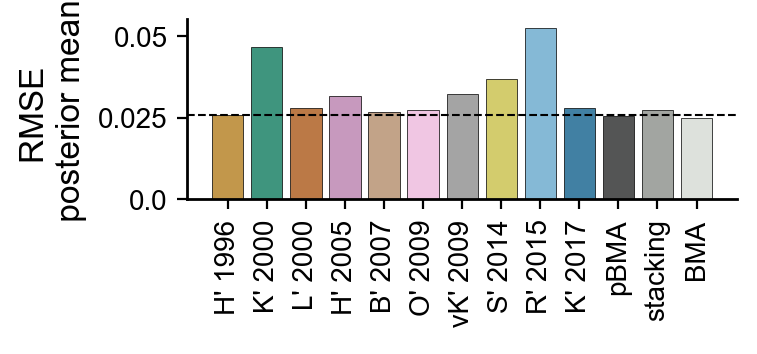

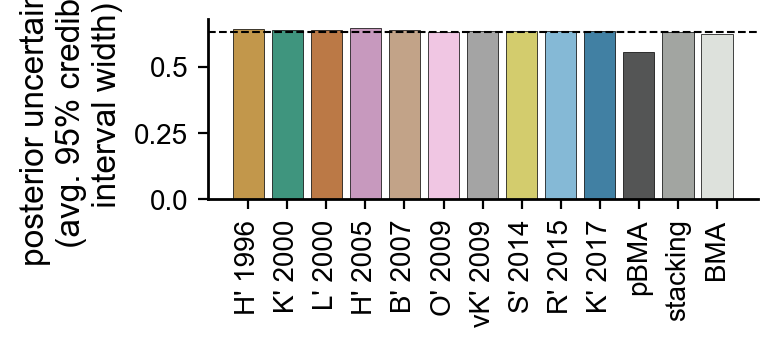

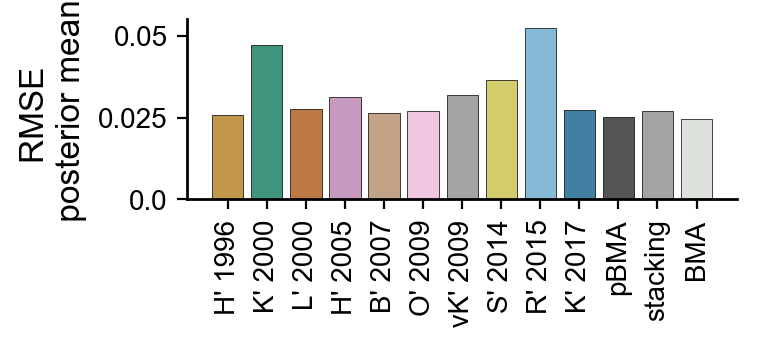

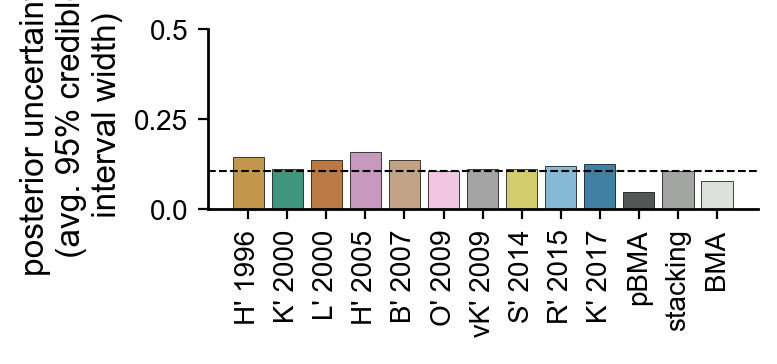

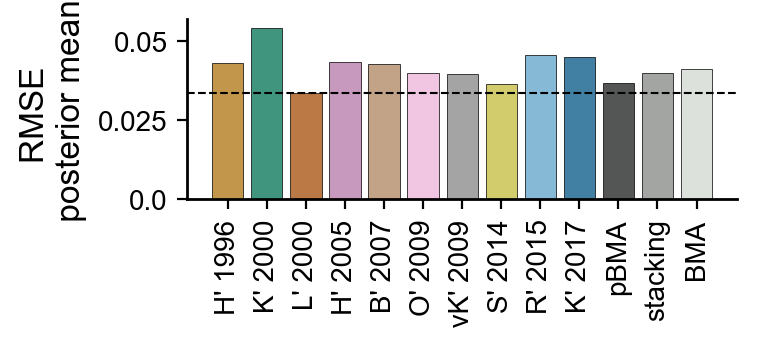

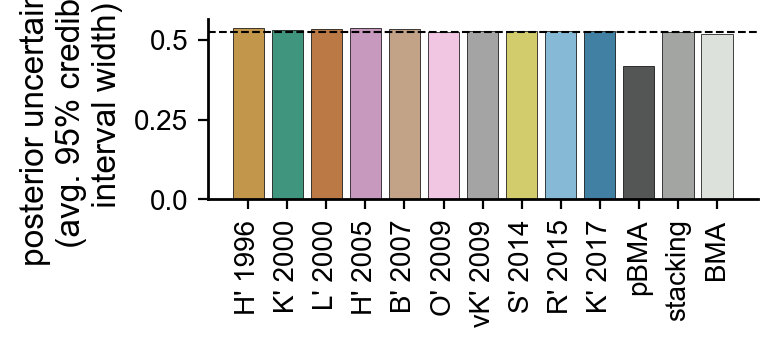

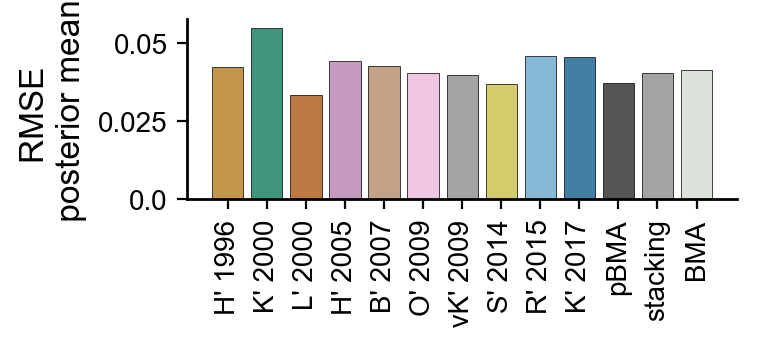

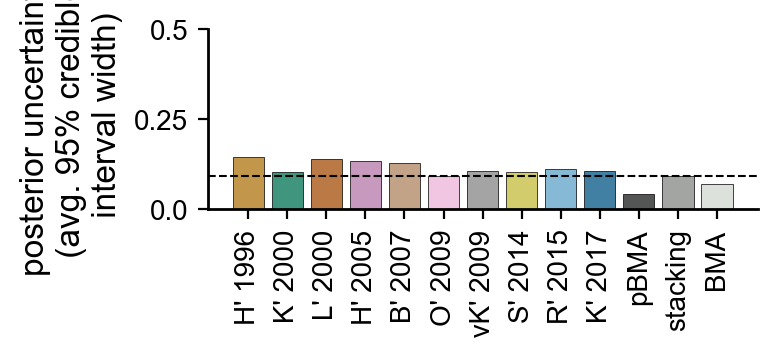

In [9]:
# for full data case, plot error and uncertainty for PPC and posterior push forward
savedir = '../../../results/MAPK/mmi/Keyes_2020_data/'
    
for compartment in ['CYTO','PM']:
    
    RMSE_postpred = [model_errors['40min'][compartment]['RMSE_postpred'][model] for model in model_names] + [mmi_errors['40min'][compartment][name]['RMSE_postpred'] for name in mmi_errors['40min'][compartment].keys()]
    uncert95_postpred = [model_uncertainties['40min'][compartment]['cred95_postpred'][model] for model in model_names] + [mmi_uncertainties['40min'][compartment][name]['cred95_postpred'] for name in mmi_uncertainties['40min'][compartment].keys()]
    RMSE = [model_errors['40min'][compartment]['RMSE'][model] for model in model_names] + [mmi_errors['40min'][compartment][name]['RMSE'] for name in mmi_errors['40min'][compartment].keys()]
    uncert95 = [model_uncertainties['40min'][compartment]['cred95'][model] for model in model_names] + [mmi_uncertainties['40min'][compartment][name]['cred95'] for name in mmi_uncertainties['40min'][compartment].keys()]

    # make plots
    min_index_RMSE = np.argmin(RMSE_postpred[0:8])
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], RMSE_postpred, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    
    xlim = ax.get_xlim()
    ax.plot(xlim, [RMSE_postpred[min_index_RMSE]]*2, 'k--', linewidth=0.75)
    ax.set_xlim(xlim)
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
    ax.set_yticks([0.0, 0.025, 0.05])
    ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
    print(savedir + compartment, 'RMSE', ax.get_ylim())
    fig.savefig(savedir + compartment + '_RMSE_postpred.pdf', transparent=True)

    min_index_95 = np.argmin(uncert95_postpred[0:8])
    print(uncert95_postpred[min_index_95])
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], uncert95_postpred, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    xlim = ax.get_xlim()
    ax.plot(xlim, [uncert95_postpred[min_index_95]]*2, 'k--', linewidth=0.75)
    ax.set_xlim(xlim)
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
    # ax.set_ylim([0, 0.5])
    ax.set_yticks([0.0, 0.25, 0.5])
    ax.set_yticklabels([0.0, 0.25, 0.5], fontsize=10.0)
    print(savedir + compartment, '95', ax.get_ylim())
    fig.savefig(savedir + compartment + '_uncertainty_95_postpred.pdf', transparent=True)

    # make plots
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], RMSE, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
        
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
    ax.set_yticks([0.0, 0.025, 0.05])
    ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
    print(savedir + compartment, 'RMSE', ax.get_ylim())
    fig.savefig(savedir + compartment + '_RMSE.pdf', transparent=True)

    min_index_95 = np.argmin(uncert95[0:8])
    print(uncert95[min_index_95])
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], uncert95, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    xlim = ax.get_xlim()
    ax.plot(xlim, [uncert95[min_index_95]]*2, 'k--', linewidth=0.75)
    ax.set_xlim(xlim)
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
    # ax.set_ylim([0, 0.5])
    ax.set_yticks([0.0, 0.25, 0.5])
    ax.set_yticklabels([0.0, 0.25, 0.5], fontsize=10.0)
    print(savedir + compartment, '95', ax.get_ylim())
    fig.savefig(savedir + compartment + '_uncertainty_95.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/1515550413.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


../../../results/MAPK/mmi/Keyes_2020_data/CYTO rel_err_final_10_min (0.0, 0.058795231995534)
0.11772707570484224


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/1515550413.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_62032/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


../../../results/MAPK/mmi/Keyes_2020_data/PM rel_err_final_10_min (0.0, 0.03138217427812327)
0.07864180028379165


KeyError: 'huang_ferrell_1996'

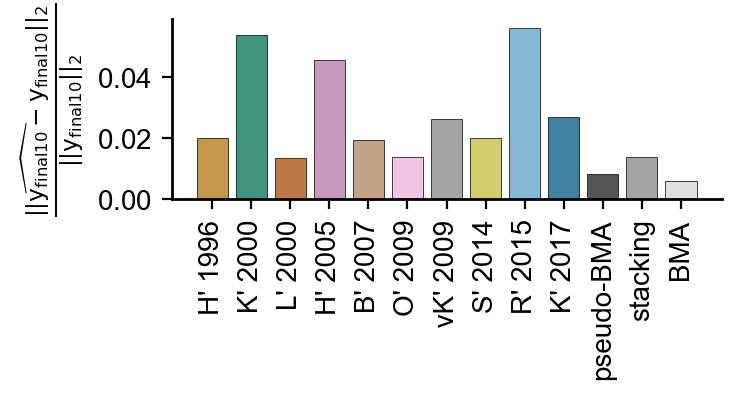

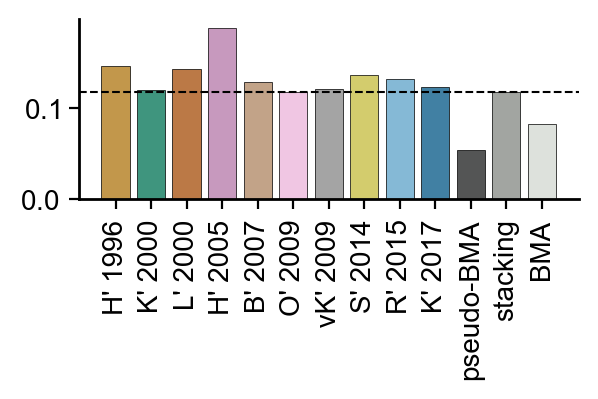

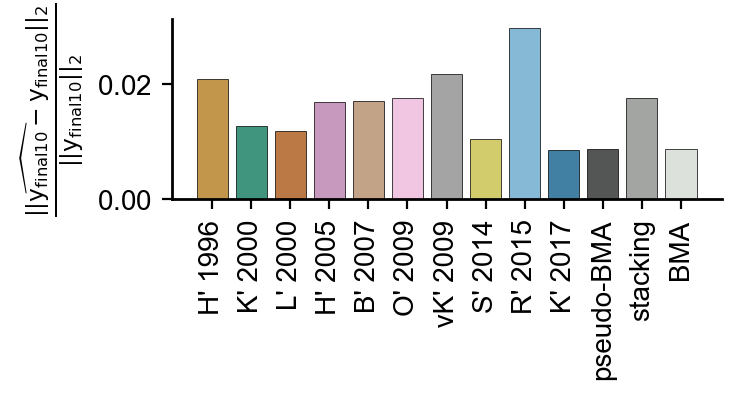

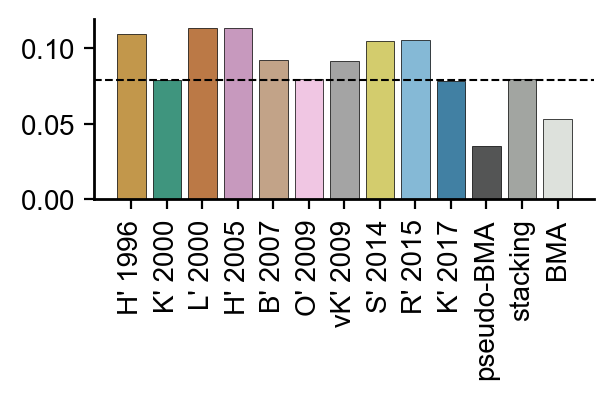

In [10]:
testing_errors = {'CYTO':[], 'PM':[]}
testing_uncertainties = {'CYTO':[], 'PM':[]}

final_10_min_errors = {'CYTO':[], 'PM':[]}
final_10_min_uncertainties = {'CYTO':[], 'PM':[]}

for time_len in ['', '_30min', '_20min', '_10min']:
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'
    
    for compartment in ['CYTO','PM']:
        #### first for testing error and uncertainty (exclude 40min case)
        if key != '40min':
            rel_err_test = [model_errors[key][compartment]['rel_err_test'][model] for model in model_names] + [mmi_errors[key][compartment][name]['rel_err_test'] for name in mmi_errors[key][compartment].keys()]
            uncert95_test = [model_uncertainties[key][compartment]['cred95_test'][model] for model in model_names] + [mmi_uncertainties[key][compartment][name]['cred95_test'] for name in mmi_uncertainties[key][compartment].keys()]

            testing_errors[compartment].append(rel_err_test)
            testing_uncertainties[compartment].append(uncert95_test)

            # make plots
            fig, ax = get_sized_fig_ax(2.75, 0.9)
            bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rel_err_test, edgecolor='k', alpha=0.85)
            for i, br in enumerate(bar):
                br.set_facecolor(colors[i])
                
            ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
            ax.set_ylabel(r'$\frac{||\widehat{y_{\rm test}} - y_{\rm test}||_2}{||y_{\rm test}||_2}$', fontsize=12.0)
            # ax.set_yticks([0.0, 0.025, 0.05])
            # ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
            print(savedir + compartment, 'rel_err_test', ax.get_ylim())
            fig.savefig(savedir + compartment + '_rel_err_test.pdf', transparent=True)

            min_index_95 = np.argmin(uncert95_test[0:8])
            print(uncert95_test[min_index_95])
            fig, ax = get_sized_fig_ax(2.5, 0.9)
            bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], uncert95_test, edgecolor='k', alpha=0.85)
            for i, br in enumerate(bar):
                br.set_facecolor(colors[i])
            xlim = ax.get_xlim()
            ax.plot(xlim, [uncert95_test[min_index_95]]*2, 'k--', linewidth=0.75)
            ax.set_xlim(xlim)
            ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
            fig.savefig(savedir + compartment + '_uncert95_test.pdf', transparent=True)
        
        #### now for final 10min of sim time error and uncertainty
        rel_err_final_10_min = [model_errors[key][compartment]['rel_err_final_10_min'][model] for model in model_names] + [mmi_errors[key][compartment][name]['rel_err_final_10_min'] for name in mmi_errors[key][compartment].keys()]
        uncert95_final_10_min = [model_uncertainties[key][compartment]['cred95_final_10_min'][model] for model in model_names] + [mmi_uncertainties[key][compartment][name]['cred95_final_10_min'] for name in mmi_uncertainties[key][compartment].keys()]

        final_10_min_errors[compartment].append(rel_err_final_10_min)
        final_10_min_uncertainties[compartment].append(uncert95_final_10_min)

        # make plots
        fig, ax = get_sized_fig_ax(2.75, 0.9)
        bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rel_err_final_10_min, edgecolor='k', alpha=0.85)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])
            
        ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
        ax.set_ylabel(r'$\frac{||\widehat{y_{\rm final 10}} - y_{\rm final 10}||_2}{||y_{\rm final 10}||_2}$', fontsize=12.0)
        # ax.set_yticks([0.0, 0.025, 0.05])
        # ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
        print(savedir + compartment, 'rel_err_final_10_min', ax.get_ylim())
        fig.savefig(savedir + compartment + '_rel_err_test.pdf', transparent=True)

        min_index_95 = np.argmin(uncert95_final_10_min[0:8])
        print(uncert95_final_10_min[min_index_95])
        fig, ax = get_sized_fig_ax(2.5, 0.9)
        bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], uncert95_final_10_min, edgecolor='k', alpha=0.85)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])
        xlim = ax.get_xlim()
        ax.plot(xlim, [uncert95_final_10_min[min_index_95]]*2, 'k--', linewidth=0.75)
        ax.set_xlim(xlim)
        ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
        fig.savefig(savedir + compartment + '_uncert95_final_10_min.pdf', transparent=True)
plt.close('all')


0
1
2
3
4
5
6
7
8
9
10
11
12


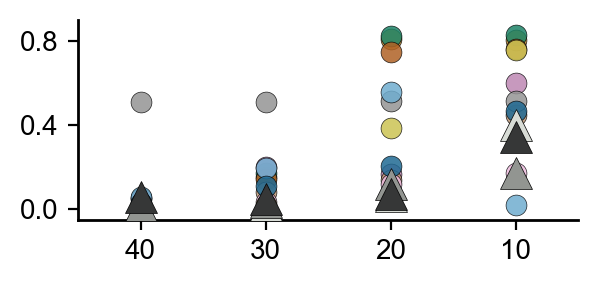

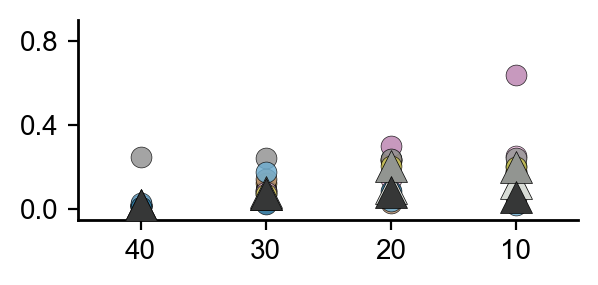

In [ ]:
fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_errors['CYTO'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pBMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    ln = ax.plot(np.flip(col), 'o', color=colors[i], markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_ylim([-0.05, 0.9])
ax.set_xlim([-0.5, 3.5])
ax.set_yticks([0.0, 0.4, 0.8],[0.0, 0.4, 0.8], fontsize=10.0)

xlim = ax.get_xlim()
leg = ax.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(2.0, 1.0), ncol=2)
export_legend(leg, '../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_rel_err_LEG.pdf')
leg.remove()

fig.savefig('../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_rel_err.pdf', transparent=True)

fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_errors['PM'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pseudo-BMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    print(i)
    ln = ax.plot(np.flip(col), 'o', color=colors[i], markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_ylim([-0.05, 0.9])
ax.set_xlim([-0.5, 3.5])
ax.set_yticks([0.0, 0.4, 0.8],[0.0, 0.4, 0.8], fontsize=10.0)

xlim = ax.get_xlim()
fig.savefig('../../../results/MAPK/mmi/Keyes_PM_final_10_min_rel_err.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_52956/1241775845.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_52956/1241775845.py:40: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25)


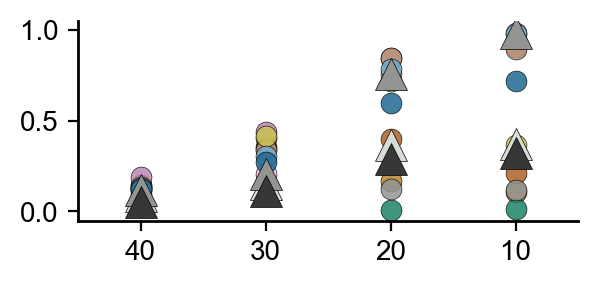

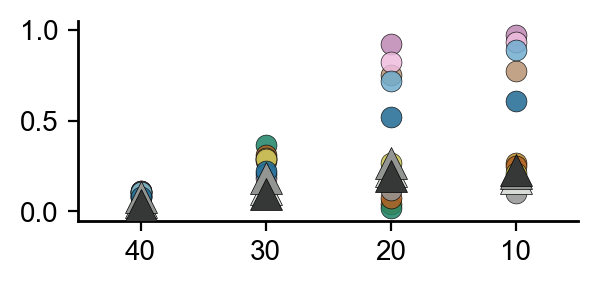

In [ ]:
fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_uncertainties['CYTO'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pBMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_yticks([0.0, 0.5, 1.0],[0.0, 0.5, 1.0], fontsize=10.0)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.5, 3.5])
fig.savefig('../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_uncert95.pdf', transparent=True)

# xlim = ax.get_xlim()
# ax.plot(xlim, [0.1]*2, '--', linewidth=1.0, color='blue', zorder=-1)
# ax.set_xlim(xlim)

fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_uncertainties['PM'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pBMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_yticks([0.0, 0.5, 1.0],[0.0, 0.5, 1.0], fontsize=10.0)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.5, 3.5])
fig.savefig('../../../results/MAPK/mmi/Keyes_PM_final_10_min_uncert95.pdf', transparent=True)

leg = ax.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(2.0, 1.0), ncol=6, 
                numpoints=1, handletextpad=-0.25, columnspacing=0.0)
export_legend(leg, '../../../results/MAPK/mmi/Keyes_PM_final_10_min_rel_err_LEG.pdf')
leg.remove()

Compute mean final 10 min rel errors and uncertainties for each model

In [ ]:
errs = final_10_min_errors['CYTO'].copy()
errs = np.array(errs)
print('The model with lowest cytoplasm error is:')
print(display_names[np.argmin(np.mean(errs, axis=0)[0:8])]) # note only do first 8, because the last 3 are the mmi methods

errs = final_10_min_errors['PM'].copy()
errs = np.array(errs)
print('The model with lowest PM error is:')
print(display_names[np.argmin(np.mean(errs, axis=0)[0:8])]) # note only do first 8, because the last 3 are the mmi methods


The model with lowest cytoplasm error is:
O' 2009
The model with lowest PM error is:
B' 2007


#### Compare SAM40 dists for the models and MMI with different len training data

In [ ]:
with open('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-SAM40s.json', 'r') as f:
    data_SAM40 = json.load(f)

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/natetest/miniforge3/envs/pymc/lib/python3.

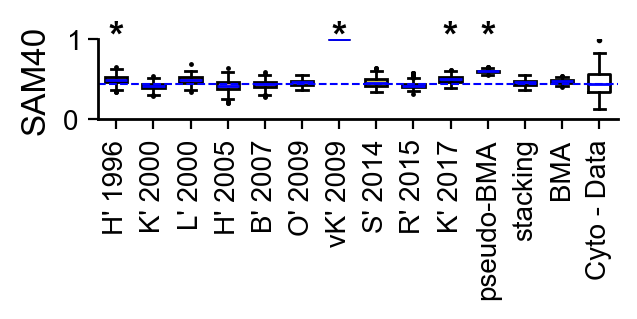

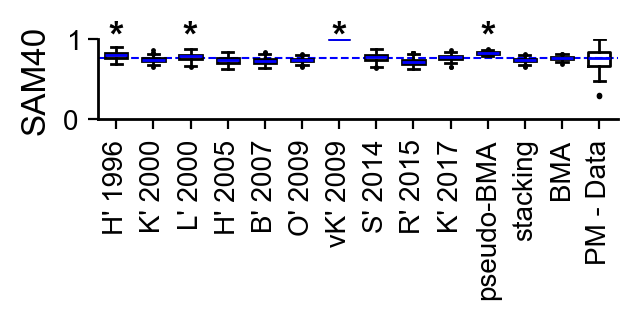

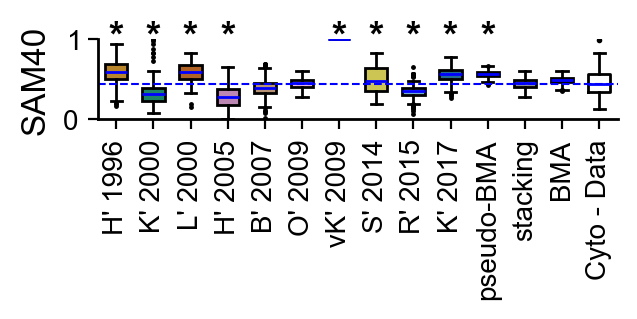

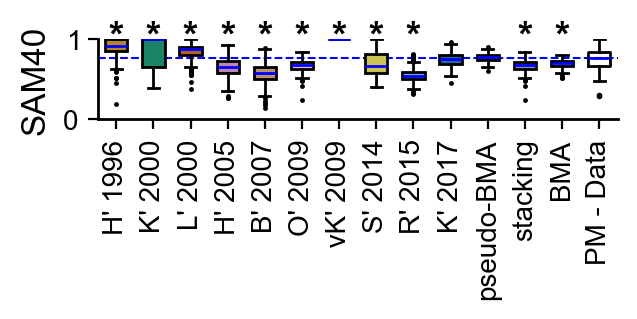

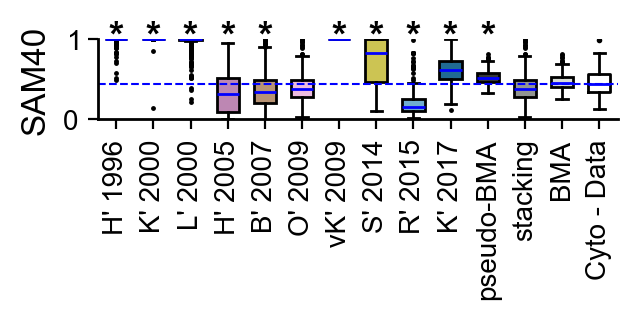

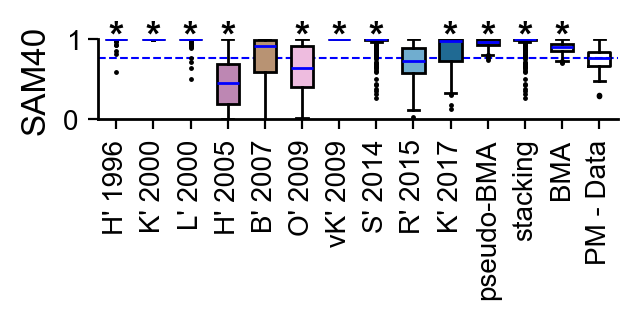

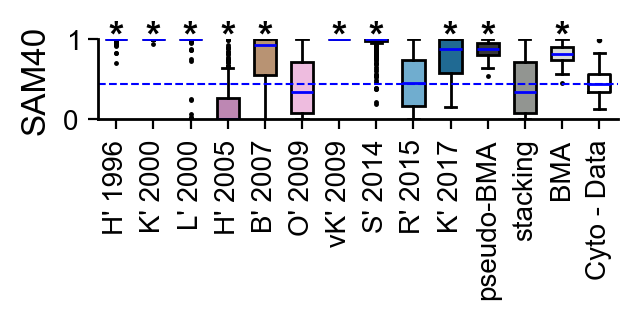

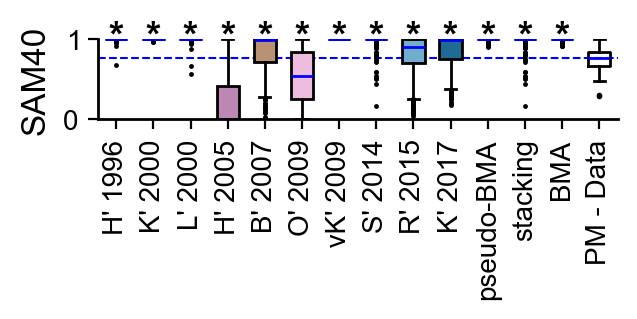

In [ ]:
import scipy.stats as stats

test_stats_cyto_pm = {'40min':{},
                      '30min':{},
                      '20min':{},
                      '10min':{}}

test_stats_cyto = {'40min':{},
                      '30min':{},
                      '20min':{},
                      '10min':{}}

test_stats_pm = {'40min':{},
                      '30min':{},
                      '20min':{},
                      '10min':{}}

width = 0.6
keys = model_names + ['pseudo-BMA', 'stacking', 'BMA']
for time_len in mmi_SAM40.keys():
    fig1, ax1 = get_sized_fig_ax(2.6, 0.4)
    fig2, ax2 = get_sized_fig_ax(2.6, 0.4)
    
    for i,model in enumerate(keys):
        SAM40_samples = {'CYTO':[], 'PM':[]}
        for compartment in ['CYTO', 'PM']:
            if model not in ['pseudo-BMA', 'stacking', 'BMA']:
                SAM40_samples[compartment] = SAM40_pred_samples[time_len][compartment][model]
            else:
                SAM40_samples[compartment] = mmi_SAM40[time_len][compartment][model]

        # use two-sample ttest with welches corrections to test the two-sided hypothesis that means are different...
        stat_test = stats.ttest_ind(SAM40_samples['CYTO'], SAM40_samples['PM'], equal_var=False, nan_policy='omit', alternative='two-sided')
        stat_test_cyto = stats.ttest_ind(SAM40_samples['CYTO'], data_SAM40['cyto'], equal_var=False, nan_policy='omit', alternative='two-sided')
        stat_test_pm = stats.ttest_ind(SAM40_samples['PM'], data_SAM40['pm'], equal_var=False, nan_policy='omit', alternative='two-sided')

        test_stats_cyto_pm[time_len][model] = stat_test.pvalue
        test_stats_cyto[time_len][model] = stat_test_cyto.pvalue
        test_stats_pm[time_len][model] = stat_test_pm.pvalue

        box = ax1.boxplot(np.array(SAM40_samples['CYTO'])[~np.isnan(SAM40_samples['CYTO'])], positions=[i], 
                         widths=width, showfliers=True, patch_artist=True, 
                         flierprops=dict(marker='o', markersize=0.75, markerfacecolor='k', markeredgecolor='k'),
                         medianprops=dict(color='b', linewidth=1.0),)
        box['boxes'][0].set_facecolor(colors[i])

        box = ax2.boxplot(np.array(SAM40_samples['PM'])[~np.isnan(SAM40_samples['PM'])], positions=[i], 
                         widths=width, showfliers=True, patch_artist=True, 
                         flierprops=dict(marker='o', markersize=0.75, markerfacecolor='k', markeredgecolor='k'),
                         medianprops=dict(color='b', linewidth=1.0),)
        box['boxes'][0].set_facecolor(colors[i])


        cutoff = 0.05
        if stat_test_cyto.pvalue < cutoff:
            ax1.text(i, 1.025, '*', fontsize=14.0, ha='center', va='center', color='k', fontweight='bold')
        if stat_test_pm.pvalue < cutoff:
            ax2.text(i, 1.025, '*', fontsize=14.0, ha='center', va='center', color='k', fontweight='bold')
        
    box = ax1.boxplot(np.array(data_SAM40['cyto'])[~np.isnan(data_SAM40['cyto'])], positions=[i+1], 
                        widths=width, showfliers=True, patch_artist=False,
                        flierprops=dict(marker='o', markersize=1.0, markerfacecolor='k', markeredgecolor='k'),
                        medianprops=dict(color='b', linewidth=1.0))
    
    xlim = ax1.get_xlim()
    ax1.plot(xlim, np.nanmedian(data_SAM40['cyto'])*np.array([1,1]), 'b--', linewidth=0.75)
    ax1.set_xlim(xlim)

    box = ax2.boxplot(np.array(data_SAM40['pm'])[~np.isnan(data_SAM40['pm'])], positions=[i+1], 
                        widths=width, showfliers=True, patch_artist=False,
                        flierprops=dict(marker='o', markersize=1.0, markerfacecolor='k', markeredgecolor='k'),
                        medianprops=dict(color='b', linewidth=1.0))
    
    xlim = ax2.get_xlim()
    ax2.plot(xlim, np.nanmedian(data_SAM40['pm'])*np.array([1,1]), 'b--', linewidth=0.75, zorder=0)
    ax2.set_xlim(xlim)

    ax1.set_ylim([0, 1.0])
    ax1.set_xticks(np.arange(len(keys)+1), display_names+['pseudo-BMA', 'stacking', 'BMA', 'Cyto - Data'], fontsize=10.0, rotation=90)
    ax1.set_ylabel('SAM40', fontsize=12.0)
    
    ax2.set_ylim([0, 1.0])
    ax2.set_xticks(np.arange(len(keys)+1), display_names+['pseudo-BMA', 'stacking', 'BMA', 'PM - Data'], fontsize=10.0, rotation=90)
    ax2.set_ylabel('SAM40', fontsize=12.0)

    fig1.savefig('../../../results/MAPK/mmi/Keyes_SAM40_CYTO_'+time_len+'.pdf', transparent=True)
    fig2.savefig('../../../results/MAPK/mmi/Keyes_SAM40_PM_'+time_len+'.pdf', transparent=True)
        

huang_ferrell_1996
kholodenko_2000
levchenko_2000
hornberg_2005
birtwistle_2007
orton_2009
vonKriegsheim_2009
shin_2014
ryu_2015
kochanczyk_2017
pseudo-BMA
stacking
BMA
huang_ferrell_1996
kholodenko_2000
levchenko_2000
hornberg_2005
birtwistle_2007
orton_2009
vonKriegsheim_2009
shin_2014
ryu_2015
kochanczyk_2017
pseudo-BMA
stacking
BMA


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_52956/3239655207.py:40: UserWarning: The palette list has more values (13) than needed (2), which may not be intended.
  sns.boxplot(data=dat_df, x='model', y='value', hue='compartment', whis=(0.025, 97.5),


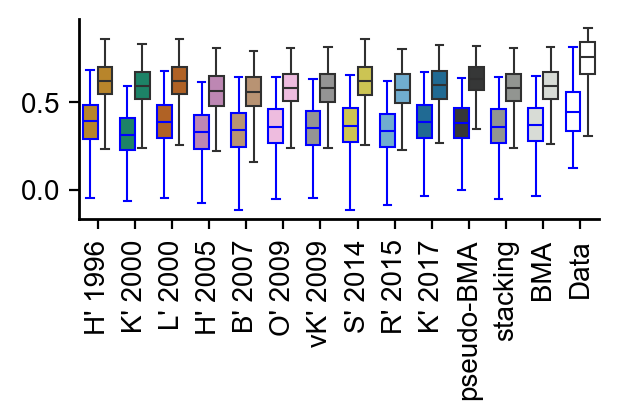

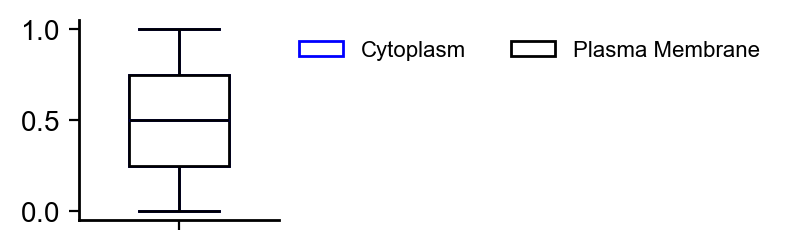

In [ ]:
# for time_len in mmi_SAM40.keys():
# turn data into a dataframe for seaborn
time_len = '40min'
dat_df = {'compartment':[], 'model':[],'value':[]}
dat_ = SAM40_post_pred_samples
for compartment in dat_.keys():
    for model in dat_[compartment].keys():
        print(model)
        for val in dat_[compartment][model]:
            dat_df['compartment'].append(compartment)
            dat_df['model'].append(model)
            dat_df['value'].append(val)

dat_= mmi_SAM40_post_pred
for compartment in dat_.keys():
    for model in dat_[compartment].keys():
        for val in dat_[compartment][model]:
            dat_df['compartment'].append(compartment)
            dat_df['model'].append(model)
            dat_df['value'].append(val)

# add data
dat = np.array(data_SAM40['pm'])[~np.isnan(data_SAM40['pm'])]
for val in dat:
    dat_df['compartment'].append('PM')
    dat_df['model'].append('Data')
    dat_df['value'].append(val)

dat = np.array(data_SAM40['cyto'])[~np.isnan(data_SAM40['cyto'])]
for val in dat:
    dat_df['compartment'].append('CYTO')
    dat_df['model'].append('Data')
    dat_df['value'].append(val)


dat_df = pd.DataFrame(dat_df)

# make the boxplot
fig, ax = get_sized_fig_ax(2.6, 1.0)
sns.boxplot(data=dat_df, x='model', y='value', hue='compartment', whis=(0.025, 97.5), 
            showfliers=False, fliersize=3.0, palette=colors, ax=ax, linewidth=0.75)
leg = ax.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(1.0, 1.0), ncol=2)
leg.remove()
ax.set_xticks(np.arange(len(display_names+['pseudo-BMA', 'stacking', 'BMA', 'Data'])), display_names+['pseudo-BMA', 'stacking', 'BMA', 'Data'], fontsize=10.0, rotation=90)
ax.set_ylabel('')
ax.set_xlabel('')

# set edgecolor of cyto boxes to blue
num_models = len(dat_df['model'].unique())
for i in range(num_models):
    if i >= len(colors):
        ax.patches[i].set_facecolor('w')
        ax.patches[i+num_models].set_facecolor('w')
    else:
        ax.patches[i].set_facecolor(colors[i])
        ax.patches[i+num_models].set_facecolor(colors[i])

    # make cyto boxes/whiskers blue
    ax.patches[i].set_edgecolor('b')
    for j in range(i*5, (i*5)+5):
        ax.lines[j].set_color('b')

fig.savefig('../../../results/MAPK/mmi/Keyes_SAM40_post_pred.pdf', transparent=True)

# legend
fig, ax = get_sized_fig_ax(1.0, 1.0)
b1 = sns.boxplot(np.array([0,1]), widths=0.5, showfliers=False, medianprops=dict(color='b', linewidth=1.0),
           boxprops=dict(facecolor='w', edgecolor='b', linewidth=1.0),
           whiskerprops=dict(color='b', linewidth=1.0), ax=ax,
           capprops=dict(color='b', linewidth=1.0))

sns.boxplot(np.array([0,1]), widths=0.5, showfliers=False, medianprops=dict(color='k', linewidth=1.0),
           boxprops=dict(facecolor='w', edgecolor='k', linewidth=1.0),
           whiskerprops=dict(color='k', linewidth=1.0), ax=ax,
           capprops=dict(color='k', linewidth=1.0),)

artists = ax.get_children()
leg = ax.legend([artists[0], artists[6]], ['Cytoplasm', 'Plasma Membrane'], fontsize=8.0, loc='upper left', bbox_to_anchor=(1.0, 1.0), ncol=2)

export_legend(leg, '../../../results/MAPK/mmi/Keyes_SAM40_legend.pdf')

In [ ]:
# cmap = mpl.colormaps['Blues'].resampled(256)
cutoff=0.05
cmap_big = mpl.colormaps['Blues'].resampled(512)
col_list = cmap_big(np.linspace(0, 1.0, 512))
col_list[np.linspace(0, 1.0, 512)<cutoff] = (1.0,1.0,1.0,1.0) #cmap_big(0)
new_blue = LinearSegmentedColormap.from_list('new_blue', col_list)

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", grid_col='w', axis_fontsize=11,  **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=axis_fontsize)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=axis_fontsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color=grid_col, linestyle='-', linewidth=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/matplotlib/colors.py:1318: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/matplotlib/colors.py:1325: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


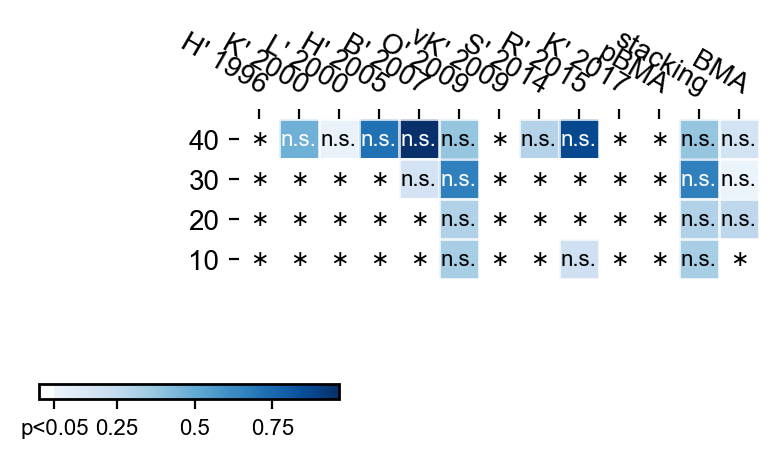

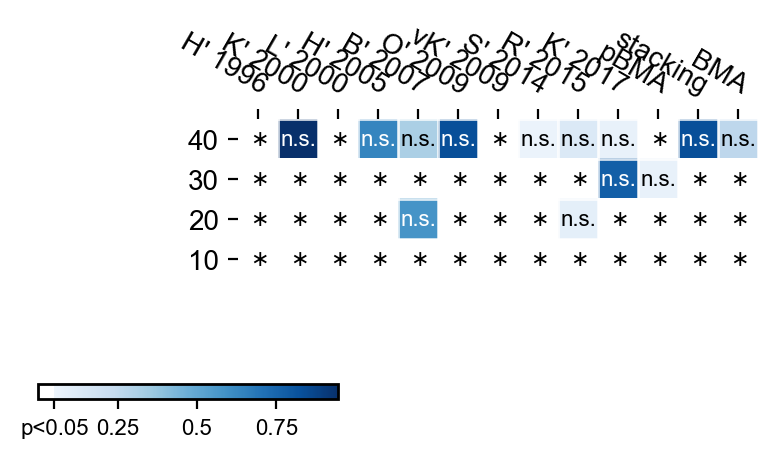

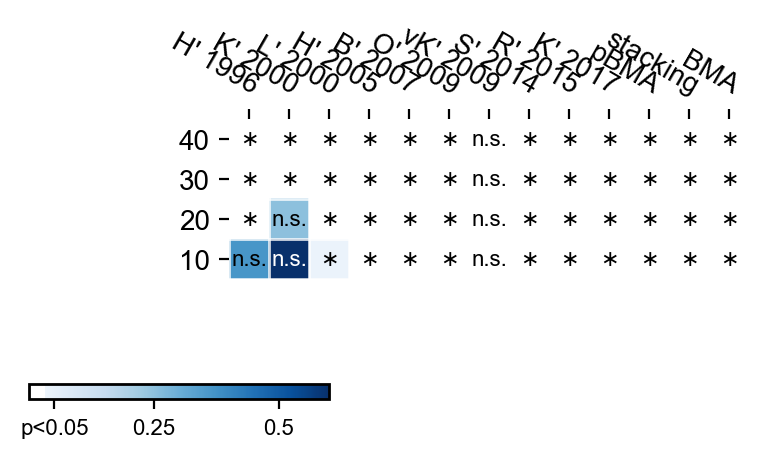

In [ ]:
stats_cyto = []
for time_dat in test_stats_cyto.values():
    stats_cyto.append(list(time_dat.values()))
stats_cyto = np.array(stats_cyto)

labels = np.ones_like(stats_cyto)
# labels[stats_cyto < cutoff] = '*'

def fmt_func(x, cutoff):
    if x < cutoff:
        return r'$\ast$'
    else:
        return 'n.s.'
fmt_func_use = lambda x, pos: fmt_func(x, cutoff)

fig, ax = get_sized_fig_ax(2.6,1.0)
im, cbar = heatmap(stats_cyto, ['40', '30', '20', '10'],
         display_names+['pBMA', 'stacking', 'BMA'], ax=ax,
            cbar_kw={'aspect':20, 'shrink':0.25, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cmap=new_blue, axis_fontsize=10.0)

cbar.set_ticks([cutoff, 0.25, 0.5, 0.75])
cbar.set_ticklabels([r'p<0.05', '0.25', '0.5', '0.75'], fontsize=8.0)

text = annotate_heatmap(im, valfmt=mpl.ticker.FuncFormatter(fmt_func_use), fontsize=8.0, threshold=0.4)

fig.savefig('../../../results/MAPK/mmi/Keyes_SAM40_CYTO_testing_pval.pdf', transparent=True)

stats_pm = []
for time_dat in test_stats_pm.values():
    stats_pm.append(list(time_dat.values()))
stats_pm = np.array(stats_pm)

fig, ax = get_sized_fig_ax(2.6,1.0)
im, cbar = heatmap(stats_pm, ['40', '30', '20', '10'],
         display_names+['pBMA', 'stacking', 'BMA'], ax=ax,
            cbar_kw={'aspect':20, 'shrink':0.25, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cmap=new_blue, axis_fontsize=10.0)

cbar.set_ticks([cutoff, 0.25, 0.5, 0.75])
cbar.set_ticklabels([r'p<0.05', '0.25', '0.5', '0.75'], fontsize=8.0)

text = annotate_heatmap(im, valfmt=mpl.ticker.FuncFormatter(fmt_func_use), fontsize=8.0, threshold=0.4)

fig.savefig('../../../results/MAPK/mmi/Keyes_SAM40_PM_testing_pval.pdf', transparent=True)


stats_compare = []
for time_dat in test_stats_cyto_pm.values():
    stats_compare.append(list(time_dat.values()))
stats_compare = np.array(stats_compare)

fig, ax = get_sized_fig_ax(2.6,1.0)
im, cbar = heatmap(stats_compare, ['40', '30', '20', '10'],
         display_names+['pBMA', 'stacking', 'BMA'], ax=ax,
            cbar_kw={'aspect':20, 'shrink':0.25, 'panchor':False, 'anchor':(0, 0),'orientation':'horizontal'}, cmap=new_blue, axis_fontsize=10.0)

cbar.set_ticks([cutoff, 0.25, 0.5])
cbar.set_ticklabels([r'p<0.05', '0.25', '0.5'], fontsize=8.0)

text = annotate_heatmap(im, valfmt=mpl.ticker.FuncFormatter(fmt_func_use), fontsize=8.0, threshold=0.4)

fig.savefig('../../../results/MAPK/mmi/Keyes_SAM40_CYTO-PM_compare_pval.pdf', transparent=True)